In [26]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# Loading Dataset

In [27]:
df = pd.read_csv(r"C:\Users\leduc\OneDrive\Desktop\bap tap uit\CS115\CS115-dataset\beophi.csv", index_col=0)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 0 to 772
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               773 non-null    int64  
 1   Glucose                   772 non-null    float64
 2   BloodPressure             773 non-null    int64  
 3   SkinThickness             773 non-null    int64  
 4   Insulin                   773 non-null    int64  
 5   BMI                       772 non-null    float64
 6   DiabetesPedigreeFunction  773 non-null    float64
 7   Age                       773 non-null    int64  
 8   Outcome                   773 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 60.4 KB


## Data cleaning 

In [29]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,773.000000,772.000000,773.000000,773.000000,773.000000,772.000000,773.000000,773.000000,773.000000
mean,3.824062,121.813472,69.952135,20.552393,79.380336,37.513342,0.469982,33.191462,0.351876
std,3.369336,40.868603,30.392494,15.927667,114.990798,155.004046,0.331145,11.744123,0.480568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,19.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.275000,0.240000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,25.000000,32.000000,0.370000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,126.000000,36.600000,0.624000,41.000000,1.000000
max,17.000000,830.000000,722.000000,99.000000,846.000000,4333.100000,2.420000,81.000000,2.000000


##### Như ta có thể thấy ở phần max của các cột BloodPressure, Insulin và BMI xuất hiện giá trị lớn bất thường
##### Giá trị outcome đáng lẽ phải là 0 hoặc 1 nhưng xuất hiện 2

In [30]:
df.isnull().sum()

Pregnancies                 0
Glucose                     1
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         1
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [31]:
df = df[df["BMI"] < 4333.1]
df[df["BMI"] >= 4333.1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [32]:
df = df[df["BloodPressure"] < 722]
df[df["BloodPressure"] >= 722]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [33]:
df = df[df["Glucose"] < 830]
df[df["Glucose"] >= 830]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [34]:
df = df[df["Outcome"] < 2]
df[df["Outcome"] >= 2]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


Để khắc phục vấn đề giá trị khuyết thiếu ta sẽ thử thực nghiệm trên 4 phương pháp.

- Drop luôn record bị khuyết
- Fill bằng giá trị 0
- Fill bằng giá trị trung bình toàn cục
- Fill bằng "KNN Imputer"

In [35]:
df_mean = df.copy(deep=True)
df_zero = df.copy(deep=True)
df_imputed = df.copy(deep=True)
df_drop = df.copy(deep=True)

In [36]:
df_zero['Glucose'] = df_zero['Glucose'].fillna(0)
df_zero['BMI'] = df_zero['BMI'].fillna(0)

df_zero.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [37]:
df_mean['Glucose'] = df_mean['Glucose'].fillna(df_mean['Glucose'].mean())
df_mean['BMI'] = df_mean['BMI'].fillna(df_mean['BMI'].mean())

df_mean.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [38]:
# uniform => các neighbors đều có trọng số như nhau
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [39]:
df_drop = df_drop.dropna()
df_drop.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Data splitting

In [40]:
y_zero = df_zero["Outcome"]  
x_zero = df_zero.drop(columns=["Outcome"], axis=1) 

In [41]:
y_drop = df_drop["Outcome"]  
x_drop = df_drop.drop(columns=["Outcome"], axis=1) 

In [42]:
y_mean = df_mean["Outcome"]  
x_mean = df_mean.drop(columns=["Outcome"], axis=1) 

In [43]:
y_imputed = df_imputed["Outcome"]  
x_imputed = df_imputed.drop(columns=["Outcome"], axis=1) 

In [44]:
x_train_zero, x_test_zero, y_train_zero, y_test_zero = train_test_split(x_zero, y_zero, test_size=0.2 ,random_state=221)
x_train_drop, x_test_drop, y_train_drop, y_test_drop = train_test_split(x_drop, y_drop, test_size=0.2 ,random_state=221)
x_train_mean, x_test_mean, y_train_mean, y_test_mean = train_test_split(x_mean, y_mean, test_size=0.2 ,random_state=221)
x_train_imputed, x_test_imputed, y_train_imputed, y_test_imputed = train_test_split(x_imputed, y_imputed, test_size=0.2 ,random_state=221)

In [45]:
x_test_mean.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [46]:
x_test_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
208,1.0,96.0,64.0,27.0,87.0,33.2,0.289,21.0
238,9.0,164.0,84.0,21.0,0.0,30.8,0.831,32.0
562,1.0,87.0,68.0,34.0,77.0,37.6,0.401,24.0
153,1.0,153.0,82.0,42.0,485.0,40.6,0.687,23.0
91,4.0,123.0,80.0,15.0,176.0,32.0,0.443,34.0


In [47]:
y_test_imputed.head()

208    0.0
238    1.0
562    0.0
153    0.0
91     0.0
Name: Outcome, dtype: float64

## GridSearchCV

In [65]:
gb_clf = GradientBoostingClassifier(random_state=221)
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_imputed, y_train_imputed)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=221),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [66]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

## Training and Evaluating

In [68]:
gb = grid_search.best_estimator_
gb.fit(x_train_drop, y_train_drop)
y_pred = gb.predict(x_test_drop)

print(classification_report(y_test_drop, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        93
           1       0.71      0.48      0.57        61

    accuracy                           0.71       154
   macro avg       0.71      0.67      0.68       154
weighted avg       0.71      0.71      0.70       154



In [69]:
gb_zero = grid_search.best_estimator_
gb_zero.fit(x_train_zero, y_train_zero)
y_pred = gb_zero.predict(x_test_zero)

print(classification_report(y_test_zero, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        93
           1       0.71      0.48      0.57        61

    accuracy                           0.71       154
   macro avg       0.71      0.67      0.68       154
weighted avg       0.71      0.71      0.70       154



In [70]:
gb_mean = grid_search.best_estimator_
gb_mean.fit(x_train_mean, y_train_mean)
y_pred = gb_mean.predict(x_test_mean)

print(classification_report(y_test_mean, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        93
           1       0.71      0.48      0.57        61

    accuracy                           0.71       154
   macro avg       0.71      0.67      0.68       154
weighted avg       0.71      0.71      0.70       154



In [71]:
gb_imputed = grid_search.best_estimator_
gb_imputed.fit(x_train_imputed, y_train_imputed)
y_pred = gb_imputed.predict(x_test_imputed)

print(classification_report(y_test_imputed, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82        93
         1.0       0.80      0.52      0.63        61

    accuracy                           0.76       154
   macro avg       0.77      0.72      0.73       154
weighted avg       0.77      0.76      0.75       154



## Feature selection

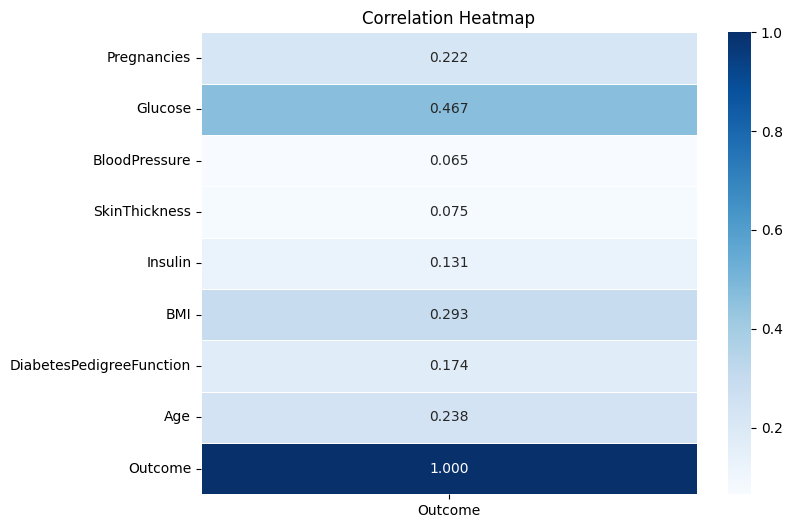

In [72]:
corr_matrix = df.corr()
corr_matrix = corr_matrix["Outcome"].to_frame()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Single feature

In [73]:
y_imputed = df_imputed["Outcome"]  
x_imputed = df_imputed.drop(columns=["Outcome"], axis=1)[["Glucose"]] 

In [74]:
x_imputed.head()

,Glucose
0,148.0
1,85.0
2,183.0
3,89.0
4,137.0


In [75]:
x_train_imputed, x_test_imputed, y_train_imputed, y_test_imputed = train_test_split(x_imputed, y_imputed, test_size=0.2 ,random_state=221)

In [76]:
gb_imputed = grid_search.best_estimator_
gb_imputed.fit(x_train_imputed, y_train_imputed)
y_pred = gb_imputed.predict(x_test_imputed)

print(classification_report(y_test_imputed, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.89      0.78        93
         1.0       0.71      0.39      0.51        61

    accuracy                           0.69       154
   macro avg       0.70      0.64      0.64       154
weighted avg       0.70      0.69      0.67       154



## Multi selective Features

In [77]:
y_imputed = df_imputed["Outcome"]  
x_imputed = df_imputed.drop(columns=["Outcome"], axis=1)[["Pregnancies", "Glucose", "BMI", "Age"]] 

In [78]:
x_imputed.head()

,Pregnancies,Glucose,BMI,Age
0,6.0,148.0,33.6,50.0
1,1.0,85.0,26.6,31.0
2,8.0,183.0,23.3,32.0
3,1.0,89.0,28.1,21.0
4,0.0,137.0,43.1,33.0


In [79]:
x_train_imputed, x_test_imputed, y_train_imputed, y_test_imputed = train_test_split(x_imputed, y_imputed, test_size=0.2 ,random_state=221)

In [113]:
gb_imputed = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=2, random_state=221)
# gb_imputed = grid_search.best_estimator_
gb_imputed.fit(x_train_imputed, y_train_imputed)
y_pred = gb_imputed.predict(x_test_imputed)

print(classification_report(y_test_imputed, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.92      0.83        93
         1.0       0.82      0.52      0.64        61

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.75       154



Khi chỉ chọn các feature có correlation trên 0.2 với target thì accuracy tăng từ 0.75 -> 0.77

Ngoài ra khá kì lạ khi best_estimator lại hoạt động kém hơn GradientBoost khi tự khởi tạo tham số

## Testing on Outlier included data

In [106]:
df = pd.read_csv(r"C:\Users\leduc\OneDrive\Desktop\bap tap uit\CS115\CS115-dataset\beophi.csv", index_col=0)

In [107]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [108]:
y = df_imputed["Outcome"]  
x = df_imputed.drop(columns=["Outcome"], axis=1)[["Pregnancies", "Glucose", "BMI", "Age"]] 

In [109]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 ,random_state=221)

In [110]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=2, random_state=221)

In [111]:
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80        91
         1.0       0.77      0.57      0.65        63
         2.0       0.00      0.00      0.00         1

    accuracy                           0.75       155
   macro avg       0.50      0.48      0.49       155
weighted avg       0.75      0.75      0.74       155



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
